In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
import time

In [340]:
SEED = 0
NUM_ANTS = int(1e5)
MAX_STEPS = 100

In [3]:
np.random.seed(SEED)

In [369]:
def square(x, y):
    f = (-2<x<2) and (-2<y<2)
    return f

def half_plane(x, y):
    f = (x + y - 1 < 0)
    return f

def ellipse(x, y):
    f = ((x - 0.25)**2/9 + (y - 0.25)**2/16 -1) < 0
    return f




In [493]:
constraints = ellipse

In [243]:
class Ants():
    def __init__(self, n:int) -> None:
        if n<=0:
            raise ValueError("Error: 'n' must be a positive integer")
        self.num_initial = n
        self.num_alive = n
        self.perc_alive = 1.0
        self.step = 0
        self.death_history = {0: 0}
        self.positions = self.initial_positions()
        self.possible_moves =  np.array([[1,0], [-1,0], [0,1], [0,-1]])
        self.position_summary = {}

    def initial_positions(self):
        
        positions = pd.DataFrame(columns = ['x', 'y'])
        positions['x'] = np.zeros(self.num_initial)
        positions['y'] = np.zeros(self.num_initial)
        
        return positions

    def move(self):
        self.step +=1
        # create random moves per each ant
        moves = self.possible_moves[np.random.choice(4, self.num_alive)]
        # make move
        self.positions += moves
        # check if the ant reaches the food
        alive = self.positions.apply(lambda pos: constraints(pos['x'], pos['y']), axis=1)
        self.death_history[self.step] = (~alive).astype(int).sum()
        self.num_alive -= self.death_history[self.step]
        self.perc_alive = self.num_alive/self.num_initial
        self.positions = self.positions[alive]
        return self.death_history[self.step]
    
    def summarize_positions(self):
        summary = self.positions.value_counts()
        self.position_summary[self.step]= summary
        return summary



In [276]:
class Grid():
    def __init__(self, height:int, width:int, default_value=np.nan, constraints=None) -> None:
        
        assert height>0
        assert width>0
        self.height = height
        self.width = width
        self.index = np.flip(np.arange(self.height)) - self.height//2
        self.columns = np.arange(self.width) - self.width//2
        self.default_value = default_value
        
        self.default_grid = None
        self.initialize_grid()
        self.grid = self.default_grid
        #self.update_grid(changes)
        self.mask = None
        self.mask = self.initialize_mask(constraints)


    def initialize_grid(self):
        grid = np.full([self.height, self.width], self.default_value)
        grid = pd.DataFrame(data=grid, index=self.index, columns=self.columns)
        self.default_grid = grid
        return grid

    def update_grid(self, changes, from_default=True):
        #if changes!=None:
        # if from_default=True it starts the changes form the default grid, otherise fromt the actual one
        if from_default:
            self.grid = self.default_grid.copy()
        # update the grid
        if changes.size>=1:
            
            for x,y in changes.index:
                # the grid could be smaller than the indeces in 'changes'
                if x in set(self.columns) and y in set(self.index):
                    self.grid.at[y,x] = changes[x,y]

        return self.grid

    def initialize_mask(self, constraints):
        if constraints!=None:
            # create every possible combination between 2 arrays
            mask = pd.DataFrame(index = pd.MultiIndex.from_product([self.index, self.columns]))
            mask.index.set_names(['y', 'x'], inplace=True)
            # evaluate the constraint function in each point
            mask['mask'] = mask.reset_index().apply(lambda pos: not constraints(pos['x'], pos['y']), axis=1).values
            # tranform from 1D to 2D
            mask = mask.unstack(level=1) # level=1 means that the indeces would be the y
            # drop the name "mask" from the columns
            mask = mask.droplevel(level=0, axis=1)
            # unstack changes th order of the indexes, so we have to sorte them again
            mask = mask.sort_index(ascending=False, axis=0)
            mask = mask.sort_index(ascending=True, axis=1)
            # update the mask
            self.mask = mask
            return mask
        return None
    
    def plot(self, vmax=None, text:str=None, masked:bool=False):
        
        # add mask
        if masked:
            sns.heatmap(
                data = self.mask, 
                vmin = 0, 
                vmax = 10, 
                cmap = 'Blues', 
                annot = False,
                linewidths = 0.5,
                cbar = False
                )
        ax = sns.heatmap(
            data = self.grid, 
            vmin = 0, 
            vmax = vmax, 
            cmap = 'rocket_r', 
            annot = True,
            linecolor='white',
            linewidths = 0.5, 
            xticklabels=True, 
            yticklabels=True
            )
        
        plt.text(self.width + self.width//2, self.height//2, text, fontsize=12)
        plt.show()
        return ax
        

In [330]:
def tracking(num_ants, max_steps=1, grid_height=10, grid_width=10, wait_time:int=None, show_animation:bool=True):
    
    ants = Ants(num_ants)
    grid = Grid(grid_height, grid_width)
    start_change = pd.Series(data = [num_ants], index=[(0,0)])
    grid.update_grid(changes=start_change)
    grid.initialize_mask(constraints=constraints)

    starttime = time.time()


    while ants.step<=max_steps and ants.num_alive>0:
        clear_output(wait=True)
        ants.move()
        grid.update_grid(changes=ants.summarize_positions())
        if show_animation:
            text = '{}\t{}\n{}\t{}\n{}\t{}\n{}\t{}'.format(
                'Steps:', ants.step, 
                'Alive:', ants.num_alive, 
                'Alive%:', ants.perc_alive, 
                'Deaths now:', ants.death_history[ants.step]
                ).expandtabs()
            grid.plot(vmax=num_ants, masked=True, text=text)
        #if ants.step%1==0 or ants.step>max_steps or ants.num_alive<=0:
        print(f'step\talive\talive%\tdeath_now')
        print(f'{ants.step}\t{ants.num_alive}\t{ants.perc_alive}\t{ants.death_history[ants.step]}')

        if wait_time:
            time.sleep(wait_time - ((time.time() - starttime) % wait_time))

    death_history = pd.DataFrame.from_dict(ants.death_history, orient='index', columns=['num'])
    death_history.index.name = 'step'
    death_history.sort_index(inplace=True)


    return death_history, ants, grid

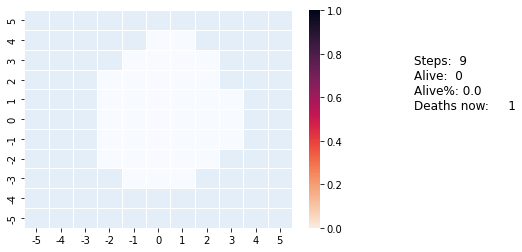

step	alive	alive%	death_now
9	0	0.0	1


In [494]:
# print('Ants creation...')
# ants = Ants(NUM_ANTS)
print('Movements tracking...')
death_history, ants, grid = tracking(num_ants=NUM_ANTS//100000, max_steps=MAX_STEPS, grid_height=11, grid_width=11, wait_time=1)

<AxesSubplot:xlabel='step'>

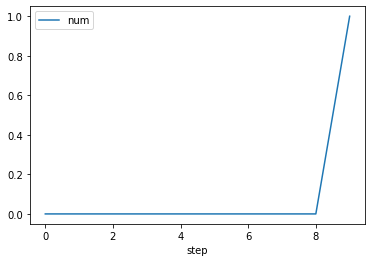

In [495]:


death_history.plot()

In [380]:
((death_history/NUM_ANTS).num*(death_history/NUM_ANTS).index)
death_history.reset_index().apply(np.prod, axis=1).sum()/NUM_ANTS

0.00011

In [496]:
grid.mask

x,-5,-4,-3,-2,-1,0,1,2,3,4,5
y,,,,,,,,,,,
5,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,False,False,True,True,True,True
3,True,True,True,True,False,False,False,False,True,True,True
2,True,True,True,False,False,False,False,False,True,True,True
1,True,True,True,False,False,False,False,False,False,True,True
0,True,True,True,False,False,False,False,False,False,True,True
-1,True,True,True,False,False,False,False,False,False,True,True
-2,True,True,True,False,False,False,False,False,True,True,True
-3,True,True,True,True,False,False,False,True,True,True,True


In [497]:
mask = pd.DataFrame(index = pd.MultiIndex.from_product([grid.index, grid.columns]))
mask.index.set_names(['y', 'x'], inplace=True)
# evaluate the constraint function in each point
mask['mask'] = mask.reset_index().apply(lambda pos: constraints(pos['x'], pos['y']), axis=1).values
mask = mask[mask['mask'].values]
mask

mask
y  x       
 4  0  True
    1  True
 3 -1  True
    0  True
    1  True
    2  True
 2 -2  True
   -1  True
    0  True
    1  True
    2  True
 1 -2  True
   -1  True
    0  True
    1  True
    2  True
    3  True
 0 -2  True
   -1  True
    0  True
    1  True
    2  True
    3  True
-1 -2  True
   -1  True
    0  True
    1  True
    2  True
    3  True
-2 -2  True
   -1  True
    0  True
    1  True
    2  True
-3 -1  True
    0  True
    1  True

In [498]:
M = pd.DataFrame(data = 0., index = list(mask.index), columns = list(mask.index))
M

,"(4, 0)","(4, 1)","(3, -1)","(3, 0)","(3, 1)","(3, 2)","(2, -2)","(2, -1)","(2, 0)","(2, 1)",...,"(-1, 2)","(-1, 3)","(-2, -2)","(-2, -1)","(-2, 0)","(-2, 1)","(-2, 2)","(-3, -1)","(-3, 0)","(-3, 1)"
"(4, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(4, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3, -1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3, 2)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(2, -2)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(2, -1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(2, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(2, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [499]:
def neighbors(x, y):
    return {(x+1, y), (x-1, y), (x, y+1), (x, y-1)}

M = pd.DataFrame(data = 0., index = list(mask.index), columns = list(mask.index))

for x,y in M.index:
    #M.at[(x, y), (x+1, y)] = 0.25 if (x+1,y) in M.columns else 0
    #M.at[(x, y), (x-1, y)] = 0.25 if (x-1,y) in M.columns else 0
    #M.at[(x, y), (x, y+1)] = 0.25 if (x,y+1) in M.columns else 0
    #M.at[(x, y), (x, y-1)] = 0.25 if (x,y-1) in M.columns else 0
    n = neighbors(x, y)
    n = n.intersection(set(M.columns))
    for neighbor in n:
        M.at[(x, y), neighbor] = 0.25
#         print((x, y), (x+1, y))
#         M.at[(x, y), (x+1, y)] = 0.25
M

,"(4, 0)","(4, 1)","(3, -1)","(3, 0)","(3, 1)","(3, 2)","(2, -2)","(2, -1)","(2, 0)","(2, 1)",...,"(-1, 2)","(-1, 3)","(-2, -2)","(-2, -1)","(-2, 0)","(-2, 1)","(-2, 2)","(-3, -1)","(-3, 0)","(-3, 1)"
"(4, 0)",0.00,0.25,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(4, 1)",0.25,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(3, -1)",0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(3, 0)",0.25,0.00,0.25,0.00,0.25,0.00,0.00,0.00,0.25,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(3, 1)",0.00,0.25,0.00,0.25,0.00,0.25,0.00,0.00,0.00,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(3, 2)",0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(2, -2)",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(2, -1)",0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.00,0.25,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(2, 0)",0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.00,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(2, 1)",0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [500]:
np.linalg.det(1-M)

-3.9151826807991344e-54

In [501]:

np.linalg.inv(1-M)


array([[ 1.95399252e-14, -4.00000000e+00, -8.28571429e+00, ...,
        -1.71428571e+00, -4.00000000e+00,  2.30926389e-14],
       [-4.00000000e+00, -3.24819536e-14, -1.02857143e+01, ...,
        -1.37142857e+01,  2.84217094e-14, -4.00000000e+00],
       [-8.08937807e+00,  2.45630993e+01,  1.02939420e+16, ...,
         1.02939420e+16, -1.44761581e+01, -1.26746669e+01],
       ...,
       [ 2.25118602e+01, -3.40201171e+01, -1.12589991e+16, ...,
        -2.02661983e+16,  2.42916171e+01,  2.15330836e+01],
       [-4.00000000e+00, -1.04430226e-14, -4.57142857e+00, ...,
        -4.57142857e+00,  7.83226695e-15, -4.00000000e+00],
       [-9.47570191e-15, -4.00000000e+00,  4.74107143e+00, ...,
         4.99107143e+00, -4.00000000e+00, -8.04728104e-15]])

In [507]:
pd.DataFrame(np.linalg.pinv(1-M), index = M.index, columns = M.columns).at[(0,0), (0,0)]

-5.887720690339249